In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import pytorch_lightning as pl
from data.Zinc_torch import Zinc_mod, Zinc_loader
import os, wandb
import sys

from models.prop import Prop_v3
from data.transform import MorganFP, MaccsFP, NormalizeTarget, NeuralFP_continous, Binning

import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
target_names = {0:"qed", 1:"sas", 2:"logP"}
target_idx = [2] # 0:qed, 1:sas, 2:logP

In [37]:
fp_transform = NeuralFP_continous("models/gnn_fp_continous_256.pt")

In [38]:
fp_transform = NeuralFP_continous("models/gnn_fp_continous_256.pt")

target_transform = Binning("models/zinc_eq_freq_bins_10_qed_sas_logP.npz",
                           target_idx=target_idx
                           )

data = Zinc_mod(root="data/Zinc/",
               transform=target_transform
               )

loader = Zinc_loader(data, subset=True, batch_size=10_000)


Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index


In [23]:
for btest in loader.test_dataloader():
    break

btest = fp_transform(btest)

In [39]:
for btrain in loader.train_dataloader():
    break

In [40]:
btrain.label.size()

torch.Size([10000, 10])

In [41]:
#test_targets = btest.y[:,target_idx].numpy()
train_targets = btrain.y[:,target_idx].numpy()

In [42]:
target_transform.bins

[array([-4.58029985,  0.5219    ,  1.29509997,  1.79939997,  2.22280002,
         2.58353996,  2.94551992,  3.31381989,  3.6881001 ,  4.16680002,
         6.66344023])]

In [24]:
#plt.hist(test_targets, bins=target_transform.bins)
# qed
print( np.histogram(train_targets, bins=target_transform.bins[0]) )
#plt.show()

(array([1013, 1012,  992,  987,  991, 1009, 1008, 1006, 1001,  981]),
 array([0.13865414, 0.52658784, 0.61501819, 0.67367953, 0.72148061,
        0.75967211, 0.79049951, 0.81994599, 0.84718364, 0.8811332 ,
        0.94739628]))

In [35]:
# sas
print(target_idx)
print( np.histogram(train_targets, bins=target_transform.bins[0]) )
#plt.show()

[1]
(array([ 987, 1000, 1031, 1001,  995, 1003,  995, 1002,  979, 1007]), array([1.39936244, 2.12297773, 2.31691217, 2.50605822, 2.6943295 ,
       2.88943219, 3.09312844, 3.36582851, 3.75487804, 4.23295593,
       6.79117584]))


In [43]:
# logP
print(target_idx)
print( np.histogram(train_targets, bins=target_transform.bins[0]) )
#plt.show()

[2]
(array([1003,  986, 1001, 1010, 1005,  993, 1010, 1030,  989,  973]), array([-4.58029985,  0.5219    ,  1.29509997,  1.79939997,  2.22280002,
        2.58353996,  2.94551992,  3.31381989,  3.6881001 ,  4.16680002,
        6.66344023]))


#### Choose target molecule

In [301]:
mols = [btest[i].mol for i in range(1000)]
labels = [str(btest[i].num_nodes) for i in range(1000)]


/home/akshay/miniforge3/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


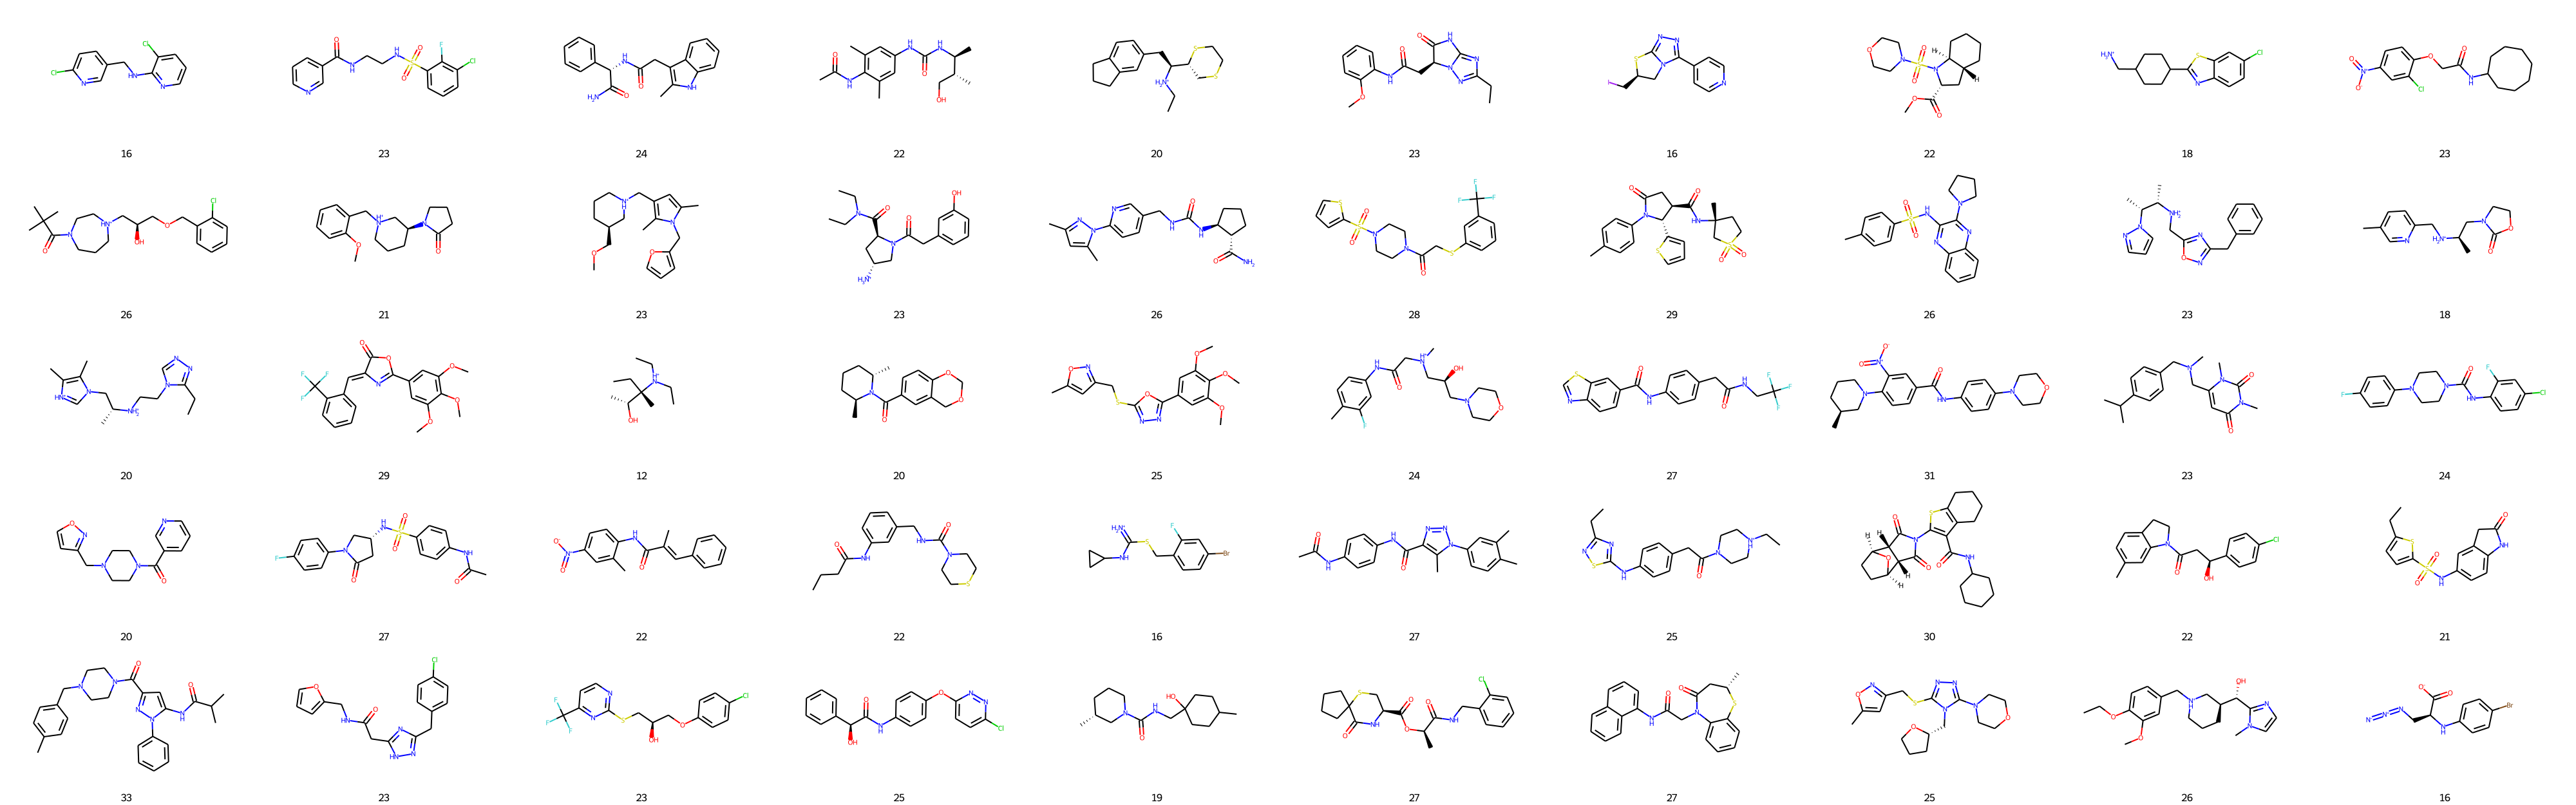

In [302]:
from rdkit.Chem import AllChem, Draw

Draw.MolsToGridImage(mols, molsPerRow=10, subImgSize=(400,250),
                    legends=labels)

tensor([[0.6346, 5.1340, 0.4606]])


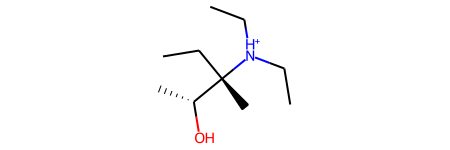

In [303]:
idx = 22
x = btest[idx].x
label = btest[idx].label
ytarget = btest[idx].y

print(btest[idx].y) 
mols[idx]

#### CRBM - Prop

In [94]:
from RBM_AA.cgbrbm_torch import CGBRBM_pl

rbm = CGBRBM_pl(fp_transform, nvis=10, ncond=256, nhid=64)

ckpt_path = "checkpoints/cgbrbm/cd_logP_v1_aux_True/attentive-etchings-20/epoch=165-step=165.ckpt"

ckpt = torch.load(ckpt_path)

rbm.load_state_dict( ckpt["state_dict"] )

<All keys matched successfully>

In [122]:
from mol_design.utils import *

def target_func(x, A):
    graph = xA_to_graph(x, A)
    fp = fp_transform(graph).fp
    fe_vis, fe_diff, recon_error = rbm.rbm.compute_loss_metric(label, fp)
    return fe_diff.detach().numpy()

In [123]:
from mol_design.qubo_opt import QuboOPT

optim_no_uncertainty = QuboOPT(x, target_func=target_func, uncertainty=False)

In [132]:
#optim_no_uncertainty.minimize(iterations=50)

#### PRop

In [304]:
from models.prop import Prop_v3

prop = Prop_v3(fp_transform, input_size=256, num_targets=3)

ckpt_path = "checkpoints/prop/neural_norm_False/v1/blooming-night-25/epoch=74-step=74.ckpt"
ckpt = torch.load(ckpt_path)

prop.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [305]:
def target_func(x, A):
    graph = xA_to_graph(x, A)
    ypred = prop(graph)[:, target_idx:target_idx+1]
    yact = ytarget[:, target_idx:target_idx+1]
    loss = F.l1_loss(ypred, yact).detach().numpy()
    return loss

In [332]:
from mol_design.qubo_opt import QuboOPT
from mol_design.utils import *

optim_no_uncertainty = QuboOPT(x, target_func=target_func, uncertainty=False)

In [333]:
optim_no_uncertainty.minimize(iterations=140)

/home/akshay/miniforge3/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


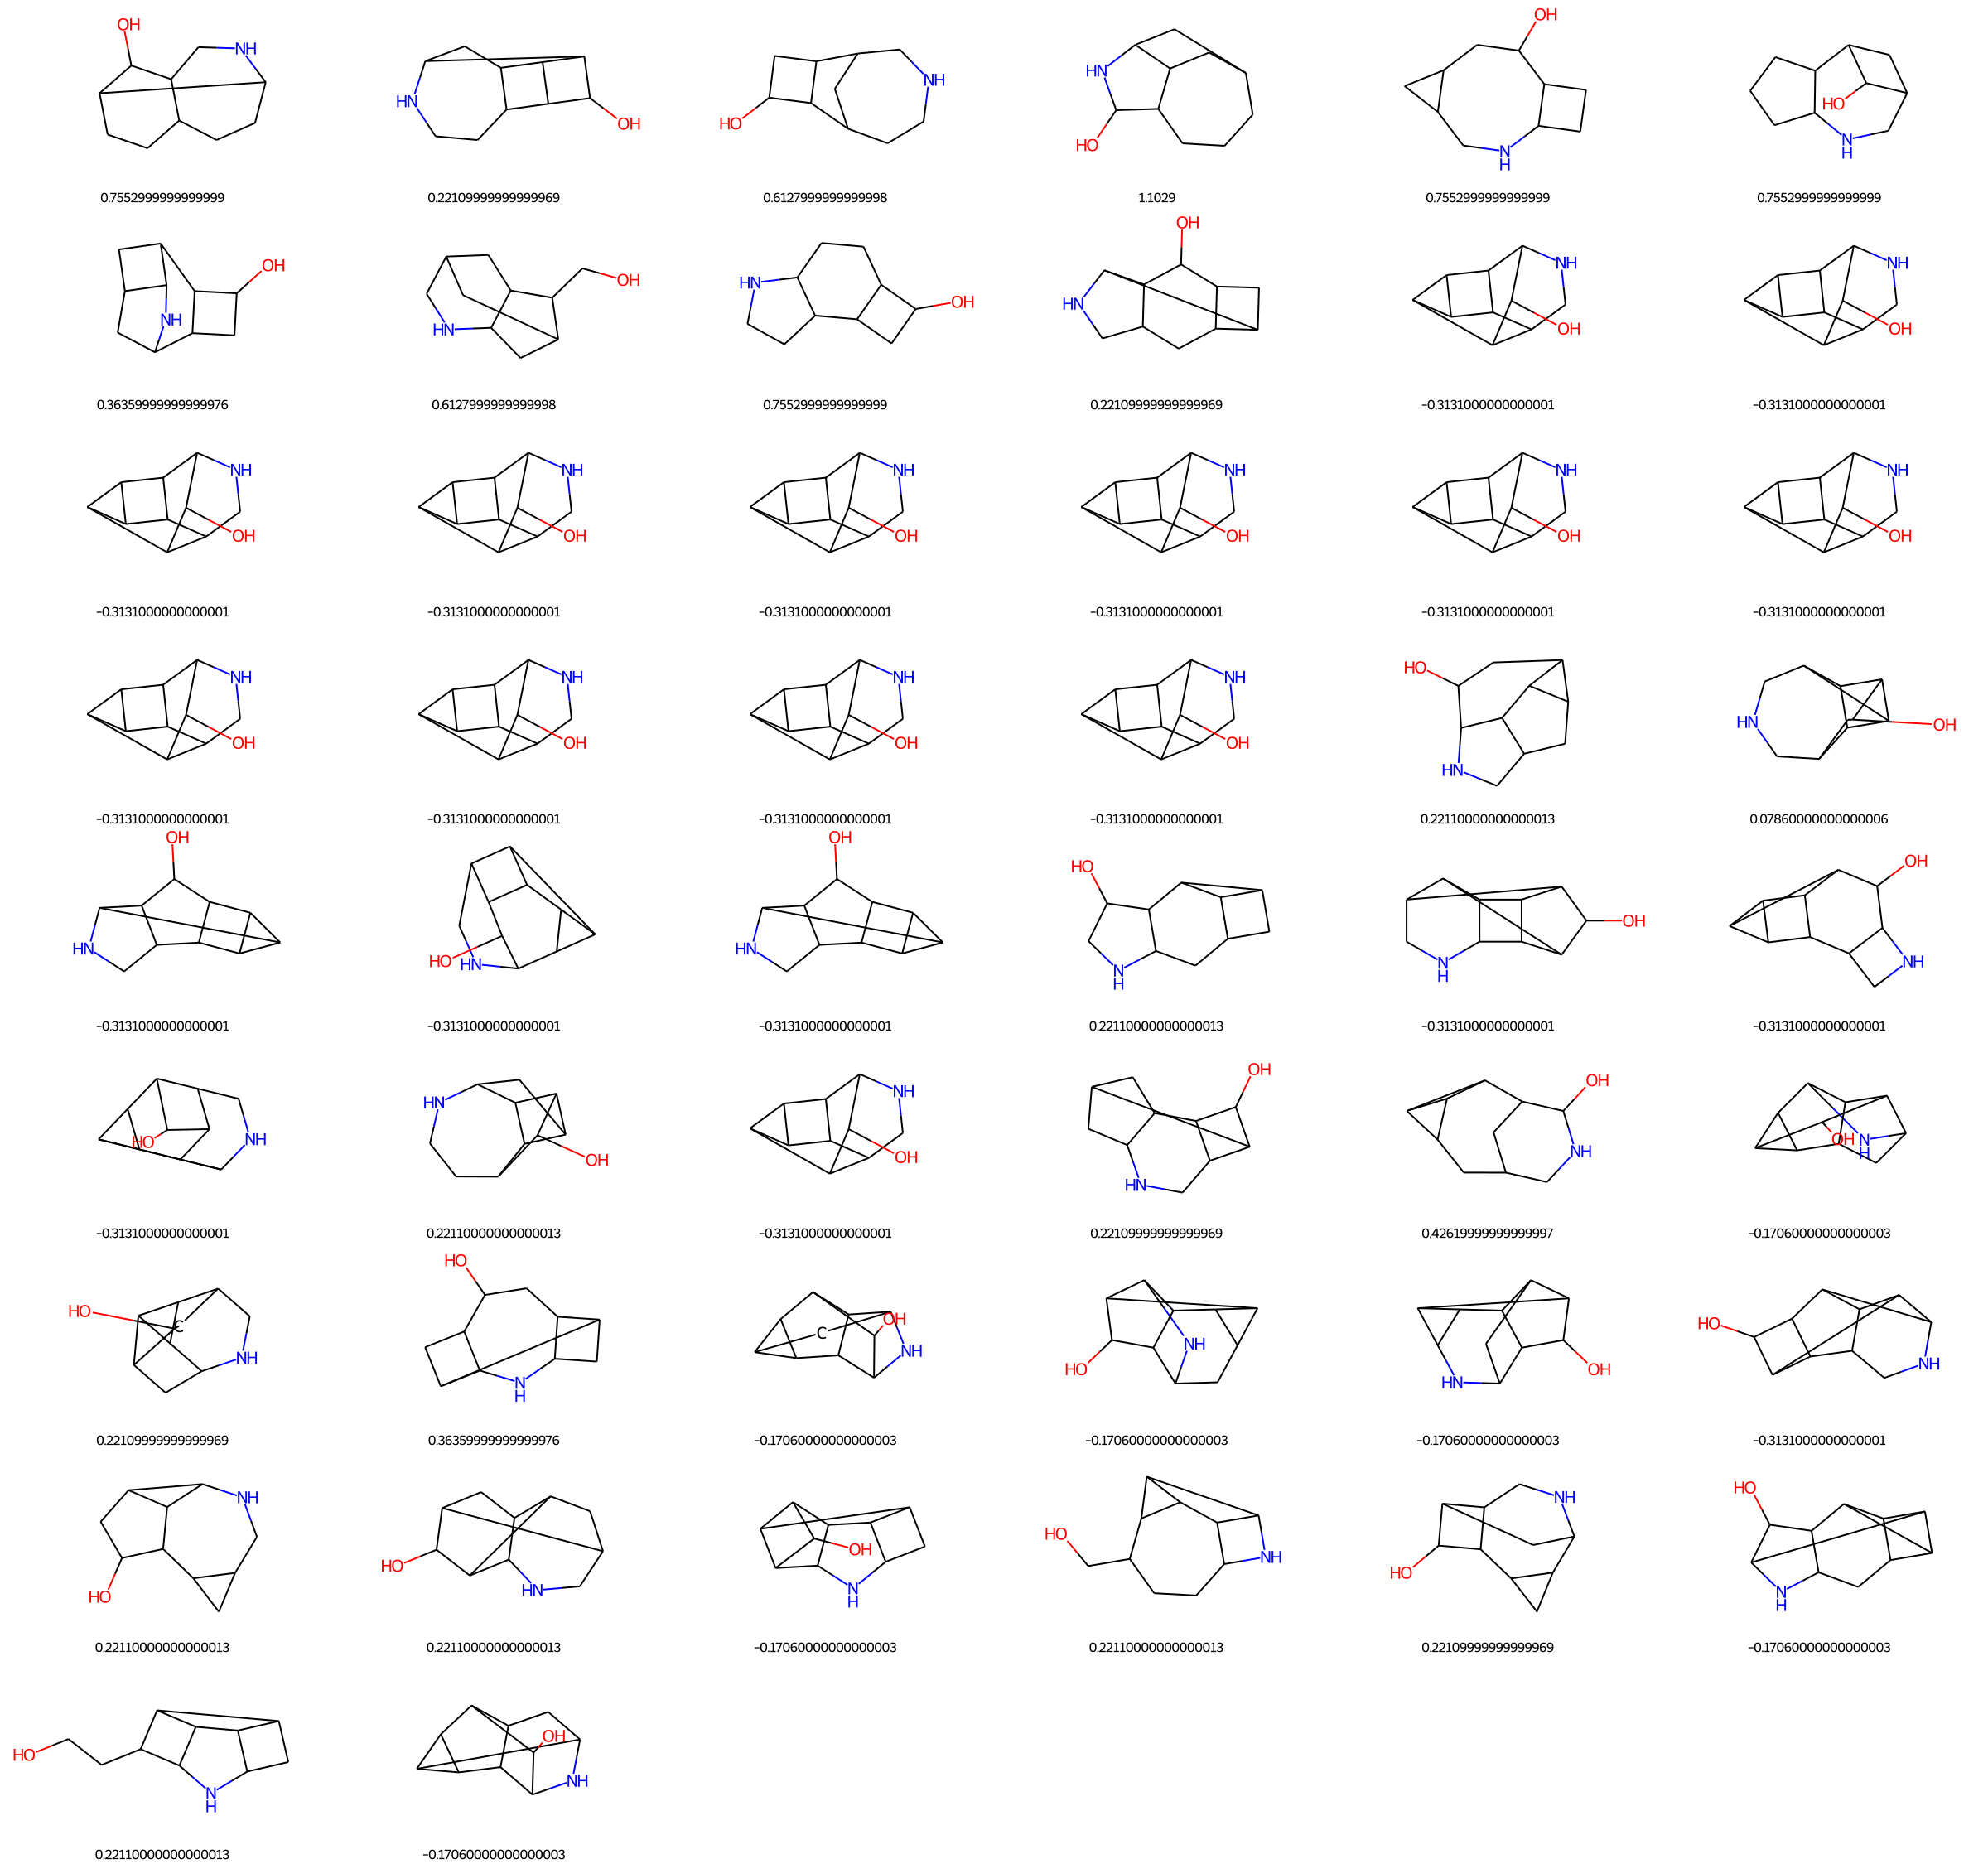

In [144]:
mols = optim_no_uncertainty.mol_history
labels = [str(g.prop["logP"]) for g in optim_no_uncertainty.graph_history]

Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(400,250),
                    legends=labels)

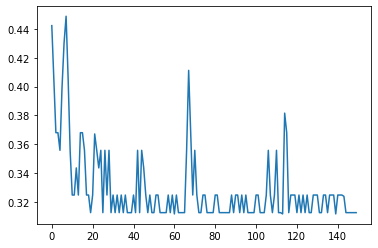

In [334]:
obj = optim_no_uncertainty.target_history
plt.plot(optim_no_uncertainty.target_history)

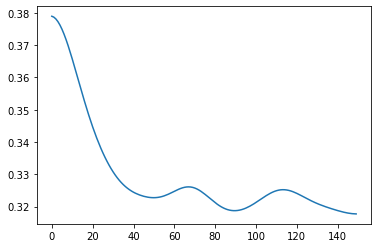

In [335]:

import scipy
#df = pd.DataFrame(obj)
#df.ewm()
filtered = scipy.ndimage.filters.gaussian_filter1d(obj, sigma=10)
plt.plot(filtered)

In [330]:
sa = []

In [336]:
sa.append(filtered)

In [ ]:
optim_no_uncertainty = QuboOPT(x, target_func=target_func, uncertainty=False, 
                                method="qc")
                                

#### Analysis

#### 1. LogP

In [128]:
target_names = {0:"qed", 1:"sas", 2:"logP"}
target_idx = 2 # 0:qed, 1:sas, 2:logP
target_name = target_names[target_idx]

fp_transform = NeuralFP_continous("models/gnn_fp_continous_256.pt")

target_transform = Binning("models/zinc_eq_freq_bins_10_qed_sas_logP.npz",
                           target_idx=target_idx
)

In [280]:
data = Zinc_mod(root="data/Zinc/",
               #transform=target_transform
               )

loader = Zinc_loader(data, subset=True, batch_size=10_000)

for btest in loader.test_dataloader():
    break

for btrain in loader.train_dataloader():
    break

Using existing file 250k_rndm_zinc_drugs_clean_3.csv
Using existing file train.index
Using existing file val.index
Using existing file test.index


In [281]:
for bval in loader.val_dataloader():
    break

In [283]:
(btrain.y.sum(dim=0) + btest.y.sum(dim=0) + bval.y.sum(dim=0)) / 12_000

tensor([0.7283, 3.0489, 2.4503])

In [289]:
a = np.concatenate((btrain.y.numpy(), btest.y.numpy(), bval.y.numpy()), axis=0)
np.std(a, axis=0)

array([0.1380612, 0.834264 , 1.4339508], dtype=float32)

In [129]:
bins = target_transform.bins
print(bins)


####### Change this here
label_idx = 7
target_label = F.one_hot(torch.Tensor([label_idx]).long(), num_classes=10).float()

lower_lim = bins[label_idx]
upper_lim = bins[label_idx+1]
print(f"Target range : {lower_lim} to {upper_lim}")
print("Target label : ", target_label)

[-4.58029985  0.5219      1.29509997  1.79939997  2.22280002  2.58353996
  2.94551992  3.31381989  3.6881001   4.16680002  6.66344023]
Target range : 3.3138198852539062 to 3.6881000995635986
Target label :  tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


In [148]:
all_graphs = []

idxs = [1,3,4,5,7]

for i in idxs:
    grs = pickle.load(open(f"logs/{target_name}_{i}_cgbrbm.pkl", "rb"))
    all_graphs.append( grs )

In [149]:
all_graphs[0] = all_graphs[0][:625]
all_graphs[2] = all_graphs[2][:527]

In [150]:
# print NUmber
for i,idx in enumerate(idxs):
    print(bins[idx], "to", bins[idx+1], " : #", len(all_graphs[i]))

0.5218999981880188 to 1.2950999736785889  : # 625
1.799399971961975 to 2.2228000164031982  : # 794
2.2228000164031982 to 2.5835399627685547  : # 527
2.5835399627685547 to 2.9455199241638184  : # 373
3.3138198852539062 to 3.6881000995635986  : # 161


In [144]:
sas_values = [ [all_graphs[i][j].prop["sas"] for j in range(len(all_graphs[i]))] for i in range(5)]
qed_values = [ [all_graphs[i][j].prop["qed"] for j in range(len(all_graphs[i]))] for i in range(5)]
logP_values = [ [all_graphs[i][j].prop["logP"] for j in range(len(all_graphs[i]))] for i in range(5)]

In [145]:
# print stats
for i in range(5):
    print(i)
    print("qed : ", np.mean(qed_values[i]), np.std(qed_values[i]))
    print("sas : ", np.mean(sas_values[i]), np.std(sas_values[i]))
    print("logP : ", np.mean(logP_values[i]), np.std(logP_values[i]))

0
qed :  0.42636171744901263 0.13249385145231418
sas :  7.13037867073132 0.8524605834493606
logP :  0.9052223529411767 0.22747533046669957
1
qed :  0.5636101377769976 0.15315521211571265
sas :  7.026705678491351 0.8392129443721025
logP :  1.9825824937027707 0.1203662242612098
2
qed :  0.5404054024312243 0.1679628159343294
sas :  7.058663734044891 0.8360938543697962
logP :  2.373630170777989 0.10282517827394046
3
qed :  0.5587737436845461 0.15277994905467432
sas :  6.946971452532981 0.732627307410627
logP :  2.7490777479892774 0.10270665671350754
4
qed :  0.5650918320614192 0.1282334950256356
sas :  6.494633186511613 0.8330511151244069
logP :  3.4814695652173935 0.10286637719972495


In [146]:
# check duplicates
for i in range(5):
    count = 0
    for j in range(len(all_graphs[i])):
        for k in range(j+1, len(all_graphs[i])):
            if all_graphs[i][j].name == all_graphs[i][k].name:
                count += 1
    print(count, count/len(all_graphs[i]))

7 0.01647058823529412
1 0.0012594458438287153
0 0.0
1 0.002680965147453083
0 0.0


In [151]:
# find in training set
for i in range(5):
    count = 0
    for j in range(len(all_graphs[i])):
        #for k in range(10_000):
        if all_graphs[i][j].name in btrain.name:
            count += 1
    print(count)

0
0
0
0
0


In [152]:
# violin plot
data = {"type": [], "x":[], "value":[]}
for i, idx in enumerate(idxs):
    # training set
    for j in range(10_000):
        if bins[idx] <= btrain[j].y[0, target_idx].item() <= bins[idx+1]:
            data["type"] += ["Training set"]
            data["x"] += [idx]
            data["value"].append( btrain[j].y[0,1].item() )
    for j in range(len(all_graphs[i])):
        data["type"] += ["Generated"]
        data["x"] += [idx]
        data["value"].append( all_graphs[i][j].prop["sas"] )


In [153]:
import pandas as pd

df = pd.DataFrame(data)

/tmp/ipykernel_17326/1546014582.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(xlabels, Fontsize=10)


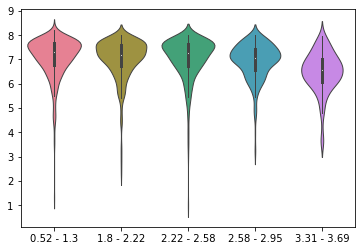

In [157]:
df2 = df[df["type"] == "Generated"]
pal = sns.color_palette("husl", 5)
ax = sns.violinplot(data=df2, x="x", y="value", #hue="x",
                #split=True, 
                palette=pal,
                linewidth=1)

#handles = ax.legend_.legendHandles
#labels = [text.get_text() for text in ax.legend_.texts]
#plt.legend(handles, labels)
ax.set_xlabel("")
ax.set_ylabel("")

xlabels = [ f"{round(bins[idx],2)} - {round(bins[idx+1], 2)}" for idx in idxs ]
ax.set_xticklabels(xlabels, Fontsize=10)
#plt.savefig("logs/qed_mols.png", bbox_inches="tight")
plt.savefig("logs/logp_mols.png", bbox_inches="tight")

In [162]:
from rdkit.Chem import Draw

794
{'qed': 0.5358124806916029, 'sas': 4.934970221257709, 'logP': 1.9002999999999999}
{'qed': 0.4202141267091121, 'sas': 6.195245881250942, 'logP': 1.8051999999999997}


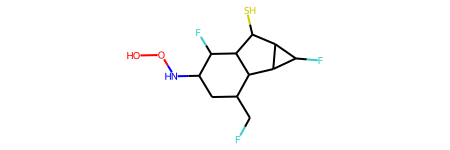

In [185]:
i = 1
mols = [all_graphs[i][j].mol for j in range(len(all_graphs[i]))]
print(len(mols))
mul = 5
rng = range(50*mul, 50*mul+50)
# Draw.MolsToGridImage(mols[rng[0] : rng[-1]], molsPerRow=5, subImgSize=(400,400),
#                     legends=[str(i) for i in rng],
#                     maxMols=500
#                     )

#selected_qed = [34, 35] #[bin_idx=0]
selected_logp = [116, 276] #[bin_idx=1]
#smols = [mols[i] for i in selected]
for j in selected_logp: print(all_graphs[i][j].prop)
mols[276]


527
91 {'qed': 0.5264407123810283, 'sas': 4.784807799400401, 'logP': 2.2479000000000005}


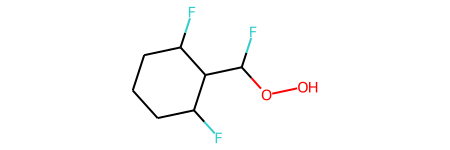

In [204]:
i = 2
mols = [all_graphs[i][j].mol for j in range(len(all_graphs[i]))]
print(len(mols))
mul = 1
rng = range(50*mul, 50*mul+50)
# Draw.MolsToGridImage(mols[rng[0] : rng[-1]], molsPerRow=5, subImgSize=(400,400),
#                     legends=[str(i) for i in rng],
#                     maxMols=500
#                     )
#selected_qed = [14, 36, 275] #[bin_idx=2]
selected_logp = [91, ] # bin_idx=2
for j in selected_logp: print(j, all_graphs[i][j].prop)
mols[91]

373
155 {'qed': 0.4164696668476837, 'sas': 5.821187338343558, 'logP': 2.9006000000000016}
287 {'qed': 0.2001830309438731, 'sas': 6.044190397015803, 'logP': 2.666400000000001}


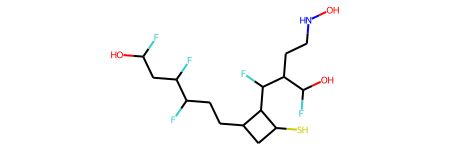

In [235]:
i = 3
mols = [all_graphs[i][j].mol for j in range(len(all_graphs[i]))]
print(len(mols))
mul = 3
rng = range(50*mul, 50*mul+50)
Draw.MolsToGridImage(mols[rng[0] : rng[-1]], molsPerRow=5, subImgSize=(400,400),
                    legends=[str(i) for i in rng],
                    maxMols=500
                    )
#selected_qed = [73] #[bin_idx=4]
selected_logp = [ 155, 287]
for j in selected_logp: print(j, all_graphs[i][j].prop)
mols[287]

161
130 {'qed': 0.5846192334965283, 'sas': 4.87273248725034, 'logP': 3.3838000000000026}
131 {'qed': 0.7025140956733574, 'sas': 3.6838133547497893, 'logP': 3.554000000000003}


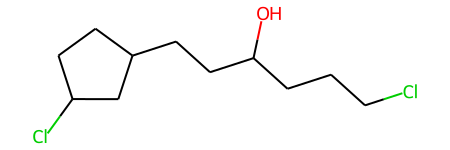

In [229]:
i = 4
mols = [all_graphs[i][j].mol for j in range(len(all_graphs[i]))]
print(len(mols))
mul = 2
rng = range(50*mul, 50*mul+50)
# Draw.MolsToGridImage(mols[rng[0] : rng[-1]], molsPerRow=5, subImgSize=(400,400),
#                     legends=[str(i) for i in rng],
#                     maxMols=500
#                     )
#selected_qed = [73] #[bin_idx=4]
selected_logp = [130, 131]
for j in selected_logp: print(j, all_graphs[i][j].prop)
mols[131]

In [127]:
# plot against train

qed_mols = all_graphs.copy()


In [236]:
logp_mols = all_graphs.copy()

In [238]:
qed_graphs = [qed_mols[i][j] for i in range(5) for j in range(len(qed_mols[i]))]
logp_graphs = [logp_mols[i][j] for i in range(5) for j in range(len(logp_mols[i]))]
total_graphs = qed_graphs + logp_graphs

In [240]:
# Joint plot - generated
from rdkit.Chem.Descriptors import ExactMolWt
gen_qed = [total_graphs[i].prop["qed"] for i in range(len(total_graphs))]
gen_logp = [total_graphs[i].prop["logP"] for i in range(len(total_graphs))]
gen_molwt = [ExactMolWt(i.mol) for i in total_graphs]


In [248]:
# trainin data
train_qed = btrain.y[:,0].numpy()
train_logp = btrain.y[:,2].numpy()
train_molwt = [ExactMolWt(btrain[i].mol) for i in range(10_000)]

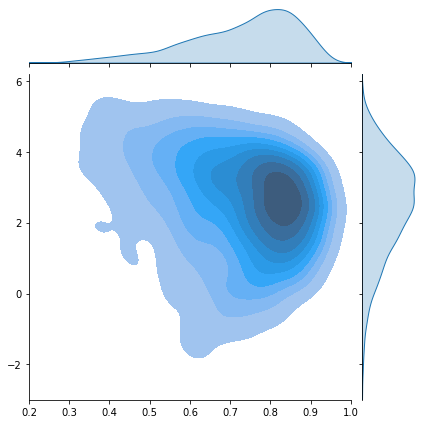

In [277]:
limit = 5000
# sns.jointplot(x=train_qed[:limit], y=train_logp[:limit], hue=train_molwt[:limit], 
#                 palette="Blues",
#                 xlim=[0.0, 1.0], ylim=[-4.5, 6.2])
# sns.kdeplot(x=train_qed[:limit], y=train_logp[:limit], fill=True)

sns.jointplot(x=train_qed[:limit], y=train_logp[:limit], #hue=train_molwt[:limit], 
                kind="kde",
                palette="Blues",
                #cbar=True,
                xlim=[0.2, 1.0], ylim=[-3, 6.2],
                joint_kws={"fill":True},
                )
plt.savefig("logs/train.png", bbox_inches="tight")

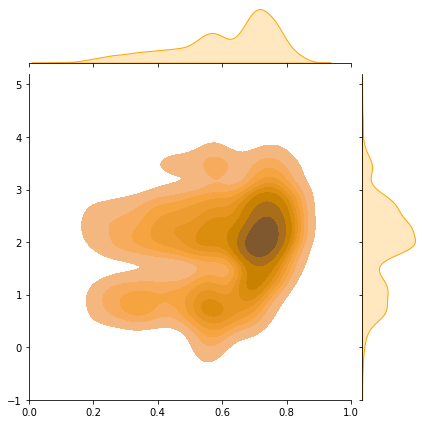

In [278]:
# sns.jointplot(x=gen_qed, y=gen_logp, #hue=gen_molwt, 
#                 palette="Blues",
#                 xlim=[0.0, 1.0], ylim=[-4.5, 6.2])
pal = plt.get_cmap("YlGn")#sns.color_palette("YlGn")
sns.jointplot(x=gen_qed, y=gen_logp, #hue=gen_molwt, 
                kind="kde",
                #=pal,
                #cbar=True,
                color="orange",
                xlim=[0., 1.0], ylim=[-1, 5.2],
                joint_kws={"fill":True},
                )
plt.savefig("logs/gen.png", bbox_inches="tight")

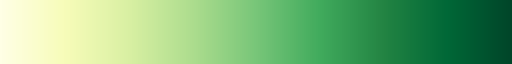

In [268]:
plt.get_cmap("YlGn")

In [20]:
prop_model = Prop_v3(transform=fp_transform, input_size=256, loss="mse", 
               num_targets=3)

ckpt = torch.load("checkpoints/prop/neural_norm_False/v1/blooming-night-25/epoch=74-step=74.ckpt")

prop_model.load_state_dict( ckpt["state_dict"] )

<All keys matched successfully>

In [78]:
from mol_design.utils import *
from mol_design.qubo_opt import QuboOPT

target_idx = 2

def target_func(x, A):
    graph = xA_to_graph(x, A)
    pred = prop_model( graph ) [0, target_idx]
    actual = btest[data_idx].target [0, target_idx]
    error = F.l1_loss(pred, actual).detach().numpy()
    return graph, error


In [64]:
data_idx = 500

x = btest[data_idx].x
print("Target props : ", btest[data_idx].target)

Target props :  tensor([[0.8515, 2.4718, 1.7787]])


In [65]:
opt = QuboOPT(x, target_func=target_func)

In [66]:
opt.minimize(iterations = 200)

Exploration step: 0  Objective: 0.1562490463256836  Props: {'qed': 0.20572628123239697, 'sas': 7.13737997907743, 'logP': -1.7717999999999958}
Exploration step: 1  Objective: 0.16374993324279785  Props: {'qed': 0.23860728039366627, 'sas': 7.261677553901137, 'logP': -1.5502999999999982}
Exploration step: 2  Objective: 0.19119906425476074  Props: {'qed': 0.3487850987849875, 'sas': 7.9640412603239685, 'logP': -1.7547999999999955}
Exploration step: 3  Objective: 0.19403326511383057  Props: {'qed': 0.2913209216783987, 'sas': 7.121872809414854, 'logP': -1.692799999999998}
Exploration step: 4  Objective: 0.1846984624862671  Props: {'qed': 0.14515177514396507, 'sas': 7.489629668754554, 'logP': -0.9845999999999975}
Exploration step: 5  Objective: 0.20903968811035156  Props: {'qed': 0.2951090583218597, 'sas': 7.433428220880126, 'logP': -2.162899999999996}
Exploration step: 6  Objective: 0.20305538177490234  Props: {'qed': 0.20859442723236685, 'sas': 7.794603979586068, 'logP': -0.00870000000000037

RDKit ERROR: [10:41:40] Explicit valence for atom # 20 F, 2, is greater than permitted
RDKit ERROR: [10:41:40] Explicit valence for atom # 20 F, 2, is greater than permitted
[10:41:40] Explicit valence for atom # 20 F, 2, is greater than permitted


AtomValenceException: Explicit valence for atom # 20 F, 2, is greater than permitted

[10:41:40] Explicit valence for atom # 20 F, 2, is greater than permitted


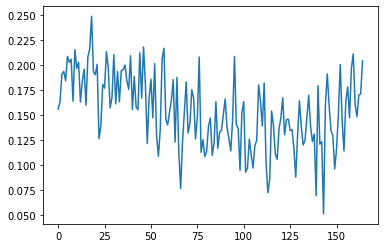

In [67]:
plt.plot(opt.target_history)

In [68]:
mols = [graph.mol for graph in opt.graph_history]
labels = [str(graph.prop["logP"]) for graph in opt.graph_history]

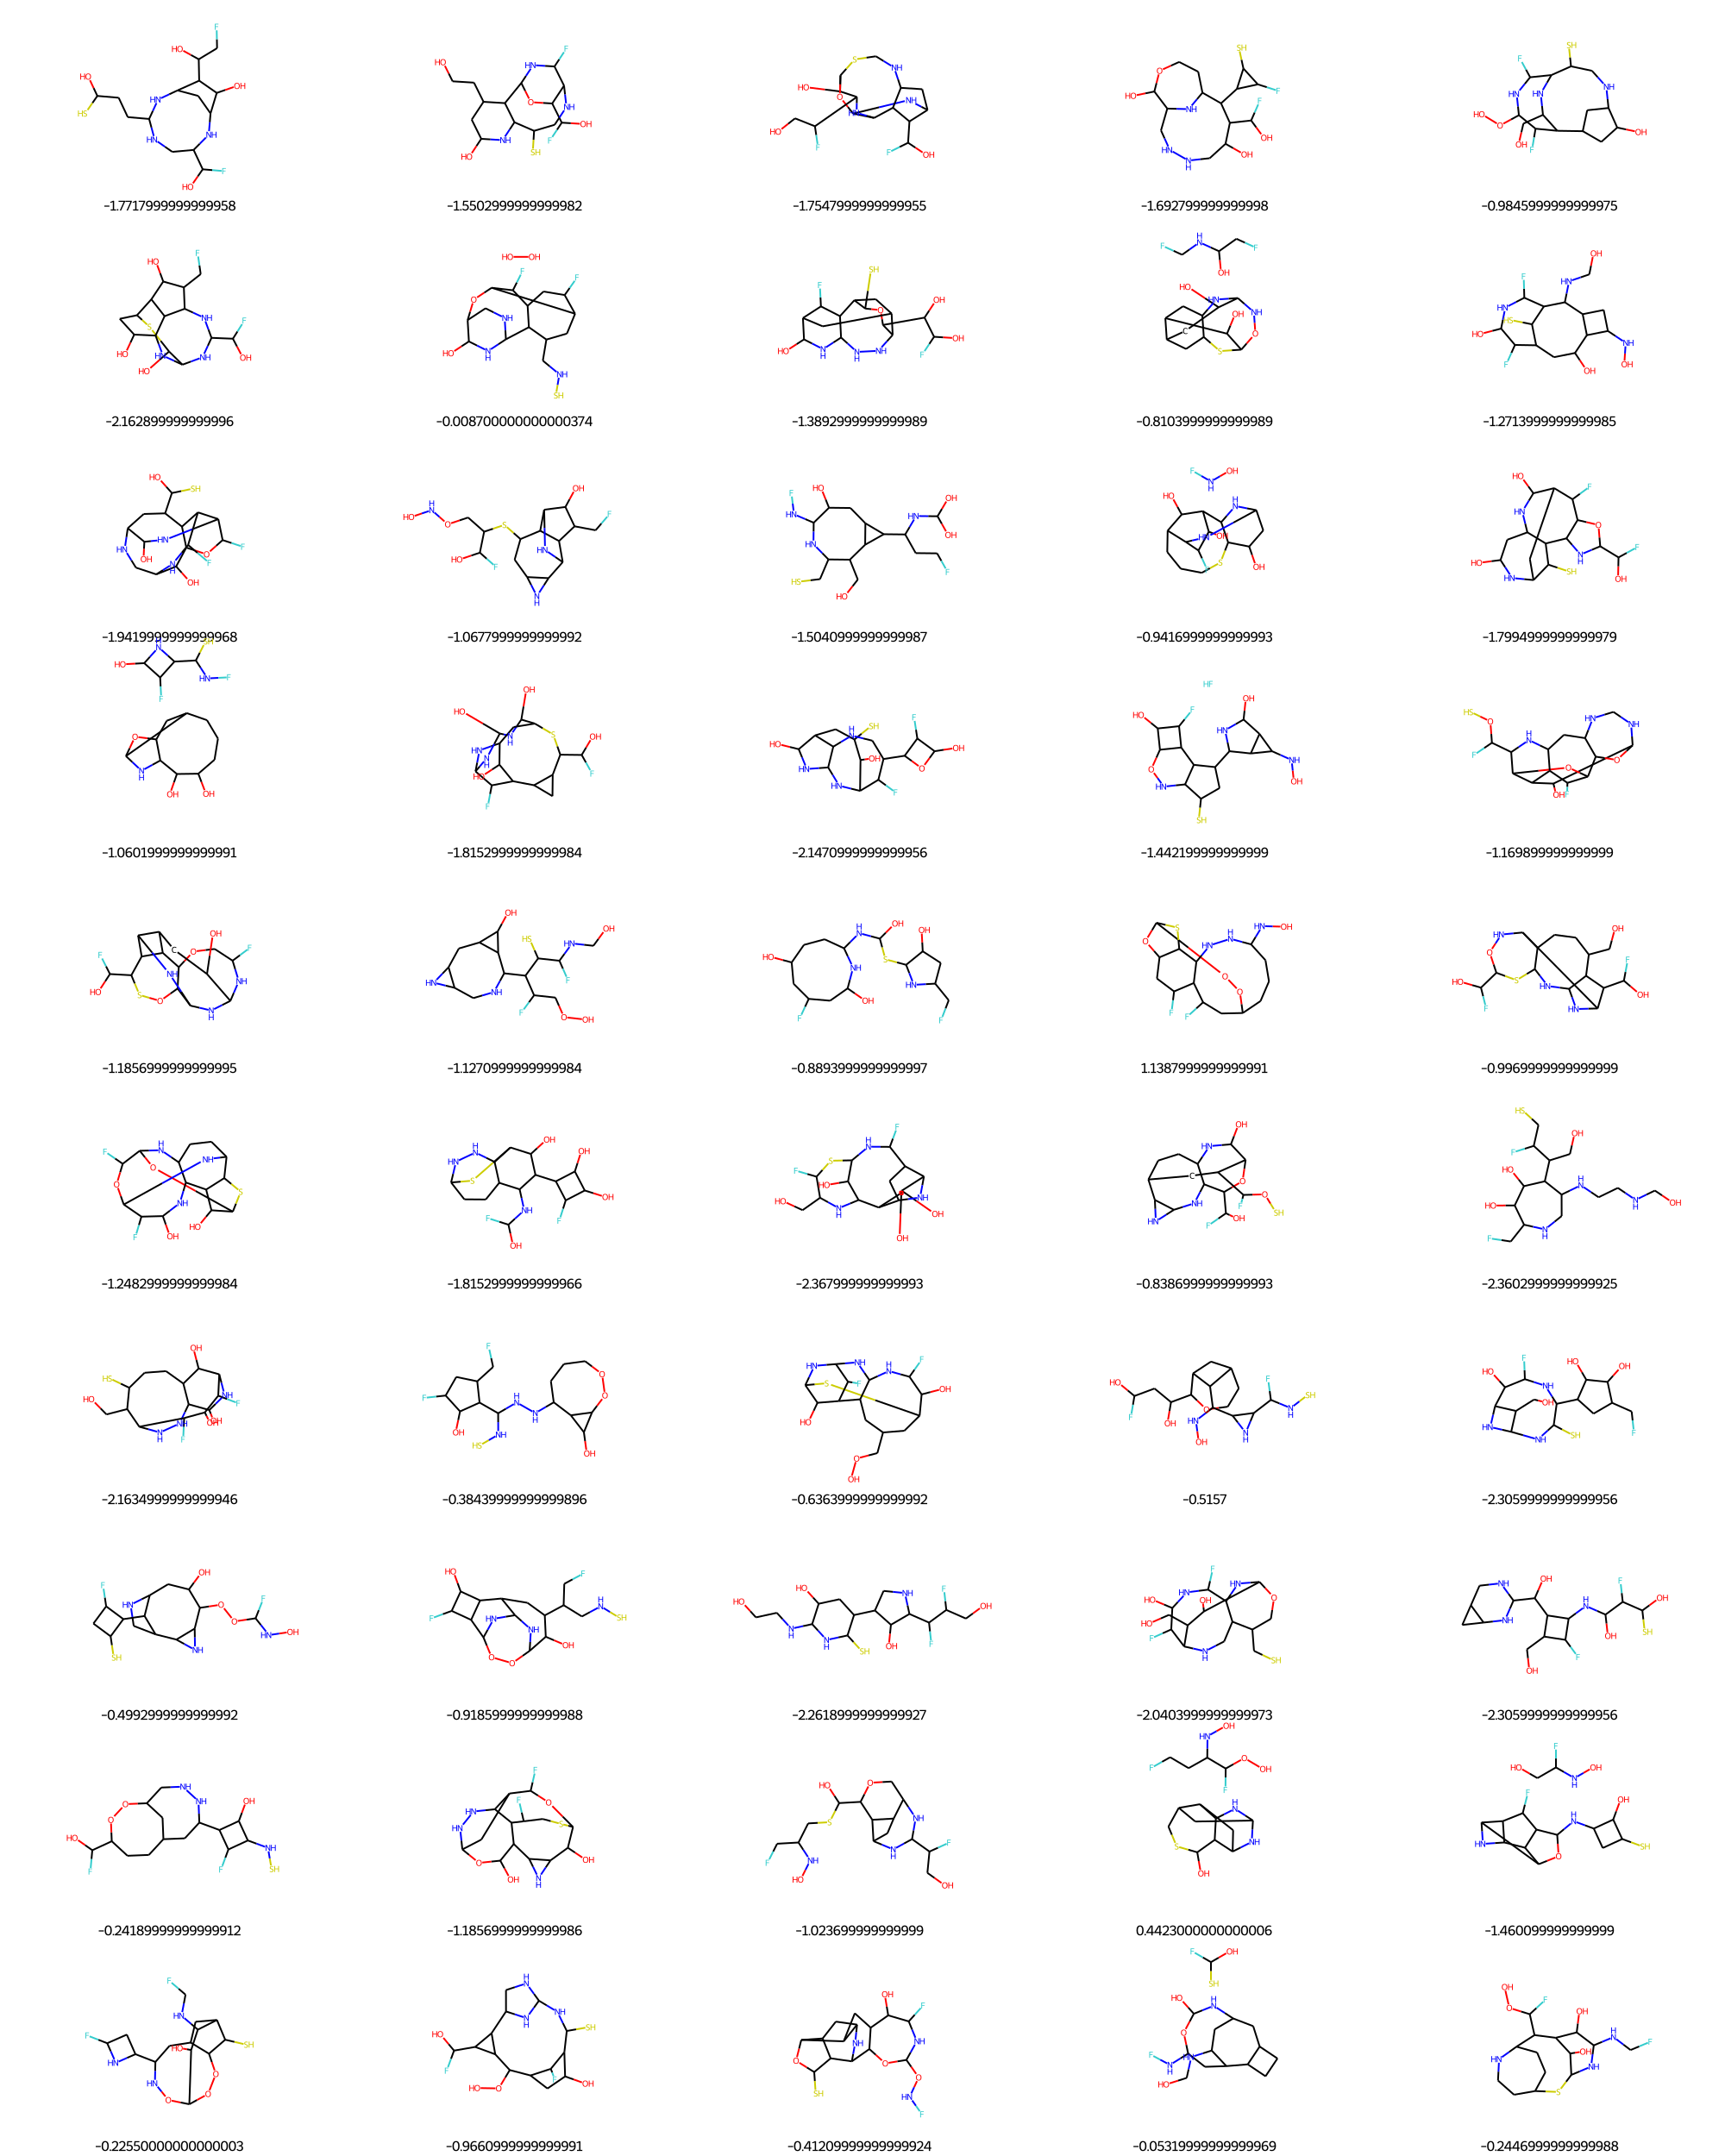

In [70]:
from rdkit.Chem import AllChem, Draw

Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(400,250),
                    legends=labels)

In [71]:
btest

165

In [89]:
opt.graph_history[15].name

'OC1CCCC2CC3OC2NC3C1O.OC1NC(C(S)NF)C1F'

In [76]:
e = opt.graph_history[15].edge_index

In [94]:
 np.sum(edges_to_matrix(e, 24), axis=1)

52.0

In [80]:
opt.graph_history[15].num_nodes

24

In [83]:
e

tensor([[ 0,  1,  1,  1,  2,  2,  2,  3,  4,  5,  6,  6,  6,  7,  7,  7,  8,  8,
          9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16,
         16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 21, 21, 21, 22, 23, 23],
        [ 1,  0,  2, 10,  1,  7,  8, 13, 10,  6,  5, 15, 19,  2,  9, 17,  2, 12,
          7, 12,  1,  4, 11, 10, 18,  8,  9, 21,  3, 14, 16, 13, 22,  6, 16, 13,
         15, 19,  7, 21, 11, 23,  6, 16, 20, 19, 12, 17, 23, 14, 18, 21]])

In [86]:
mol = opt.graph_history[15].mol

mol.GetBondBetweenAtoms(3,13).GetBondType()

rdkit.Chem.rdchem.BondType.SINGLE

In [90]:
tg = opt.graph_history[15]

In [91]:
tg.x

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0

26

In [9]:
import dimod
import neal 
import numpy as np

sampler = neal.SimulatedAnnealingSampler()

In [3]:
def generate_bqm(coeffs):
    lin, qua = {}, {}
    for i in range(len(coeffs)): lin[i] = coeffs[i]
    bqm = dimod.BinaryQuadraticModel(lin, qua, 0.0, dimod.BINARY)
    return bqm

In [154]:
N = 10
c = np.random.uniform(-1, 1, size=(N,))
def target_func(A):
    return np.dot(c, A) + np.random.rand()

In [20]:
np.dot( np.random.uniform(-1, 1, size=(N,)) , A )

-1.057559833991271

In [15]:
A = np.random.binomial(1, p=0.5, size=N)

In [155]:
Xs, Ys = [], []

for _ in range(1000):
    x = np.random.binomial(1, p=0.5, size=N)
    y = target_func(x)
    Xs.append( x )
    Ys.append( y )

In [156]:
import matplotlib.pyplot as plt

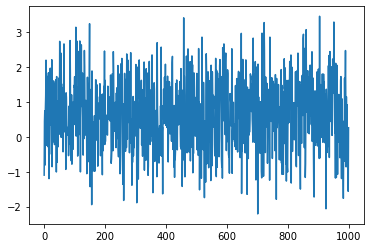

In [157]:
plt.plot(Ys)

In [158]:
# explore
Xo, Yo = [], []
for _ in range(25):
    x = np.random.binomial(1, p=0.5, size=N)
    y = target_func(x)
    Xo.append( x )
    Yo.append( y )

In [159]:
Xof = np.array(Xo)
Yof = np.array(Yo)

In [32]:
import pymc3 as pm

In [36]:

model = pm.Model()
with model:
    alpha = pm.Normal("alpha", mu=0, sigma=2, shape=N)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = sum( alpha[i] * Xof[:,i] for i in range(N))

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Yof)

map = pm.find_MAP(model=model)

In [37]:
map["alpha"]

array([-0.10113674, -0.13883391, -0.86060002,  0.73926975,  0.23708636,
       -0.83378628, -0.22180812, -0.64760594,  0.90924081,  0.27265288])

In [60]:

model = pm.Model()
with model:
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=N)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = sum( alpha[i] * Xof[:,i] for i in range(N))

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Yof)

    #trace = pm.sample(200, return_inferencedata=False)
    posterior = pm.sample(progressbar=False, return_inferencedata=False)
    #posterior_pred = pm.sample_posterior_predictive(posterior)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5313511052475691, but should be close to 0.8. Try to increase the number of tuning steps.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4060294036390333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7042290528187609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.70477627885941, but should be close to 0.8. Try to increase the numb

In [52]:
trace["alpha"]

array([[-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288],
       [-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288],
       [-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288],
       ...,
       [-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288],
       [-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288],
       [-0.10113674, -0.13883391, -0.86060002, ..., -0.64760594,
         0.90924081,  0.27265288]])

In [40]:
c

array([-0.10113674, -0.13883391, -0.86060002,  0.73926975,  0.23708636,
       -0.83378628, -0.22180812, -0.64760594,  0.90924081,  0.27265288])

In [42]:
map["alpha"]

array([-0.10113674, -0.13883391, -0.86060002,  0.73926975,  0.23708636,
       -0.83378628, -0.22180812, -0.64760594,  0.90924081,  0.27265288])

In [62]:
posterior["alpha"][-1,:]

array([-0.10113674, -0.13883391, -0.86060002,  0.73926975,  0.23708636,
       -0.83378628, -0.22180812, -0.64760594,  0.90924081,  0.27265288])

In [160]:
c

array([ 0.68320874,  0.09858603, -0.40649667, -0.29317817,  0.44380335,
       -0.80234438, -0.9862839 ,  0.96098847, -0.04744575,  0.59074472])

In [161]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)
lr.fit(Xof, Yof)

lr.coef_

array([ 0.54767954,  0.14015023, -0.31749338, -0.26281101,  0.49086059,
       -0.72974821, -0.53779196,  1.15723512,  0.00870316,  0.60521019])